In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from sklearn.datasets import make_blobs, make_moons, load_digits
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

plt.style.use('seaborn-v0_8-whitegrid')

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


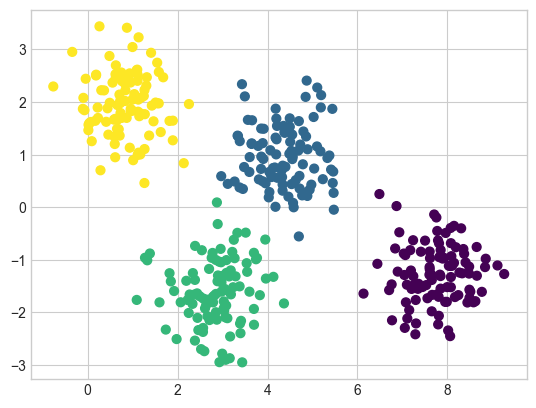

In [2]:
# there are some weaknesses o f k-means clustering
# for example, it assumes that clusters are spherical
X, y = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)
X = X[:, ::-1]  # flip axes for better plotting
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap="viridis")

In [3]:
# from an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others. for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assignment of points between them.
# one way to think about the k-means model is that it places a circle at the center of each cluster, with a radius defined by the most distant point in the cluster.
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    # plot the input data
    ax = ax or plt.gca()
    ax.axis("equal")
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap="viridis", zorder=2)
    # plot the representation of the k-means model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(
            plt.Circle(c, r, ec="black", fc="lightgray", lw=3, alpha=0.5, zorder=1)
        )

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


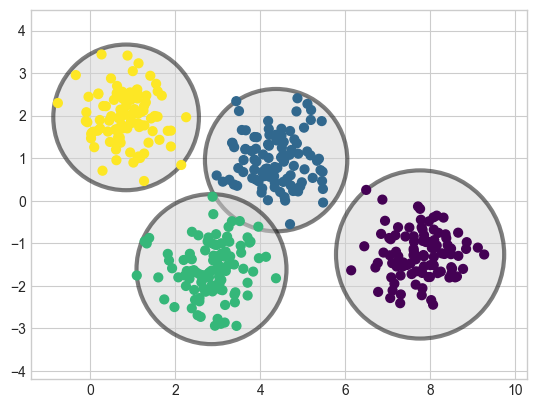

In [4]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


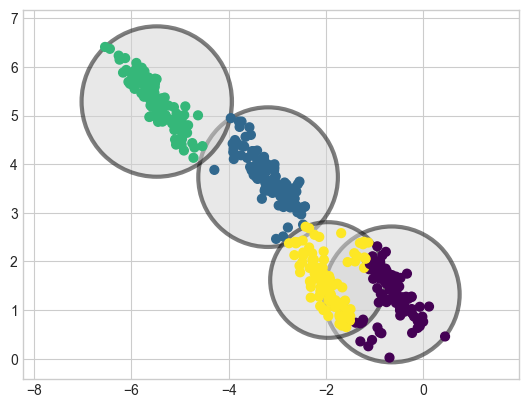

In [5]:
# an important observation for k-means is that these cluster models must be circular: k-means has no built-in way of accounting for oblong or elliptical clusters. so, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled in a way that we might not expect.
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)
# by eye, we recognize that these transformed clusters are noncircular, and thus circular clusters would be a poor fit. nevertheless, k-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters. this results in a mixing of cluster assignments where the resulting circles overlap: see especially the bottom-right of this plot.
# k-means lacks flexibility in cluster shape, and lack of probabilistic cluster assignment means that for many datasets it may not perform as well as you might hope.
# you might imagine addressing these weaknesses by generalizing the k-means model: for example, you could measure uncertainty in cluster assignment by comparing the distances of each point to all cluster centers.

Generalizing E-M: Gaussian Mixture Model

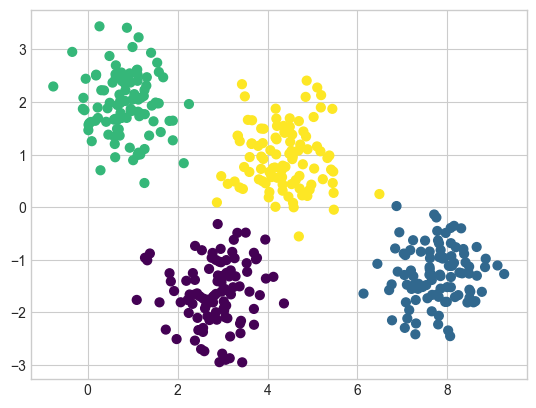

In [6]:
# a GMM attempts to find a mixture of multidimensional gaussian probability distributions that best model any input dataset. in the simplest case, GMMs can be used for finding clusters in the same manner as k-means.
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap="viridis")

In [8]:
# because a GMM contains a probabilistic model under the hood it is also possible to find probabilistic cluster assignments - in Scikit-learn this is done using the predict_proba method. this returns a matrix of size [n_samples, n_clusters] which measures the probability that any point belongs to the given cluster.
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.463 0.    0.537]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


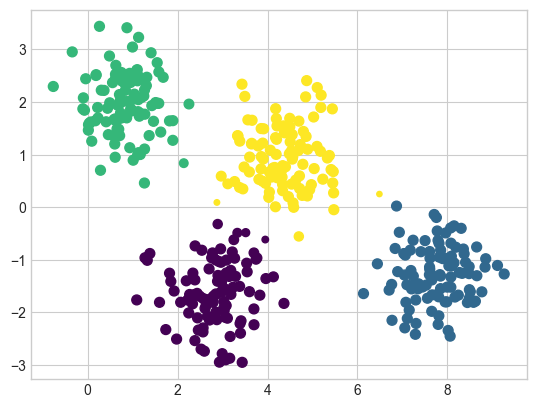

In [9]:
# we can visualize this uncertanty by, for example, making the size of each point proportional to the certainty of its prediction. we will do this by scaling the datapoints by probs.max() - probs along with a standard argument to the scatter plot function.
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", s=size)

In [10]:
# under the hood a gaussian mixture model is very similar to k-means: it uses an expectation-maximization approach which qualitatively does the following:
# 1. choose starting guesses for the location and shape
# 2. repeat until converged:
#     a. E-step: for each point, find weights encoding the probability of membership in each cluster
#     b. M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights
# the result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth gaussian model. just as in the k-means expectation-maximization approach discussed earlier, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.
# we can create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output.
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    # draw the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))


def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap="viridis", zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis("equal")
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

/var/folders/8q/0wn9p2n54hb1x_gb6ckxsdxr0000gn/T/ipykernel_29816/2138251723.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))


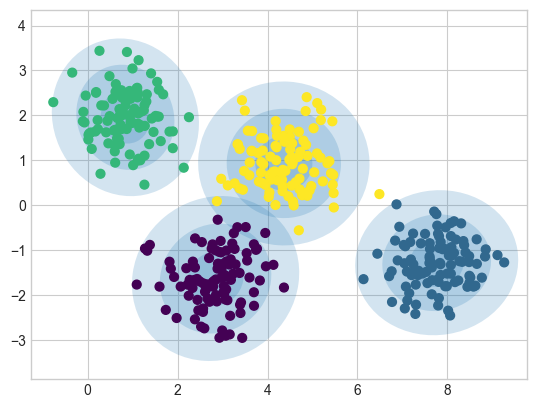

In [12]:
# with this in place we can take a look at what the four-component GMM gives us for our initial data.
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

/var/folders/8q/0wn9p2n54hb1x_gb6ckxsdxr0000gn/T/ipykernel_29816/2138251723.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))


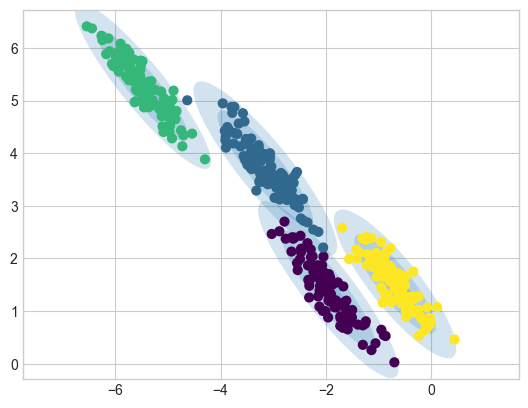

In [13]:
# similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance for the model will fit even very oblong, stretched-out clusters.
gmm = GaussianMixture(n_components=4, covariance_type="full", random_state=42)
plot_gmm(gmm, X_stretched)

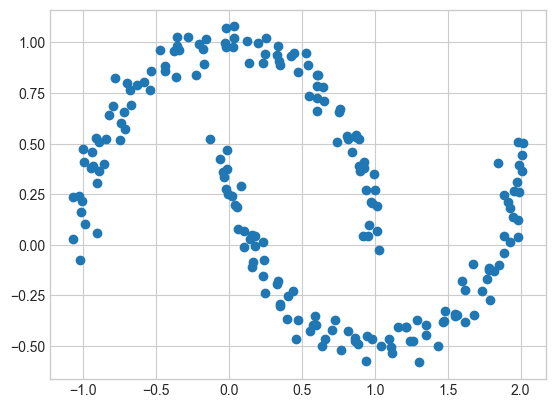

In [14]:
# choosing the covariance type
# if you look at the details of the preceding fits, you will see that convariance type option was set differently within each cluster; it is essential to set this carefully for any given problem. the default is covariance_type="diag", which means that the size fo the cluster along with each dimenasion can be set independently, with the resulting ellipse constrained to align with the axes. a slightly simpler and faster model is covariance_type="spherical", which constrains the shape of the cluster such that all dimensions are equal. the resulting clustering will have similar characteristics to that of k-means, though it is not entirely equivalent. a more complicated and computationally expensive model (especially as the number of dimensions grows) is to use covariance_type="full", which allows each cluster to be modeled as an ellipse with arbitrary orientation.

# GMM as density estimation
# though the GMM is often categorized as a cluster algoritm fundamentally it is an algo for density estimation. as an example consider some data generated from Scikit-learn's make_moons function.
Xmoon, ymoon = make_moons(200, noise=0.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1])

/var/folders/8q/0wn9p2n54hb1x_gb6ckxsdxr0000gn/T/ipykernel_29816/2138251723.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))


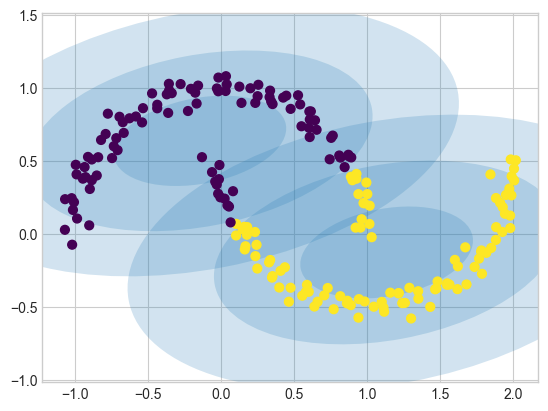

In [15]:
gmm2 = GaussianMixture(n_components=2, covariance_type="full", random_state=0)
plot_gmm(gmm2, Xmoon)

/var/folders/8q/0wn9p2n54hb1x_gb6ckxsdxr0000gn/T/ipykernel_29816/2138251723.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))


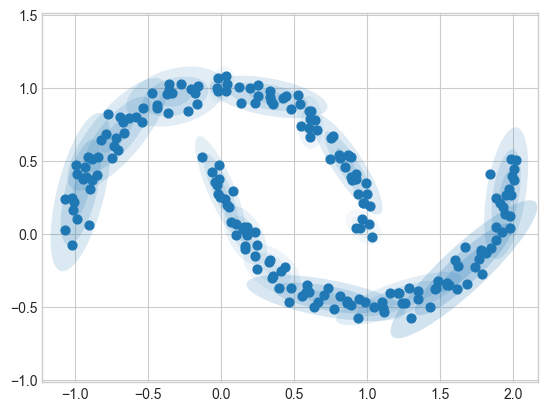

In [16]:
# if instead we use many more components and ignore the cluster lables we find a fit that is much closer to the input data.
gmm16 = GaussianMixture(n_components=16, covariance_type="full", random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

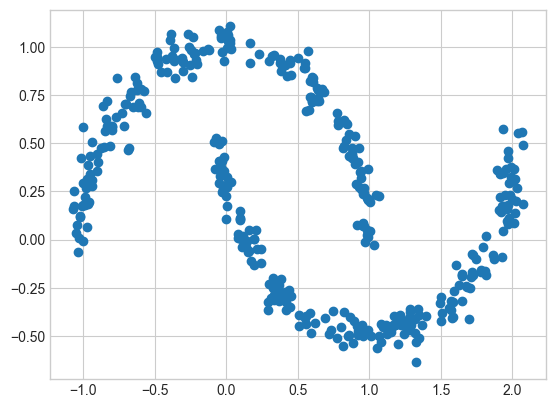

In [17]:
# here is a mixture of 16 gaussians, which corresponds to a much richer density model of the input.
# this is a gnerative model of the data distribution of the input data - that is, a model that can sample new points from the input distribution. for example here are 400 new points drawn from this 16-component GMM fit to our original data.
Xnew = gmm16.sample(400)
plt.scatter(Xnew[0][:, 0], Xnew[0][:, 1])

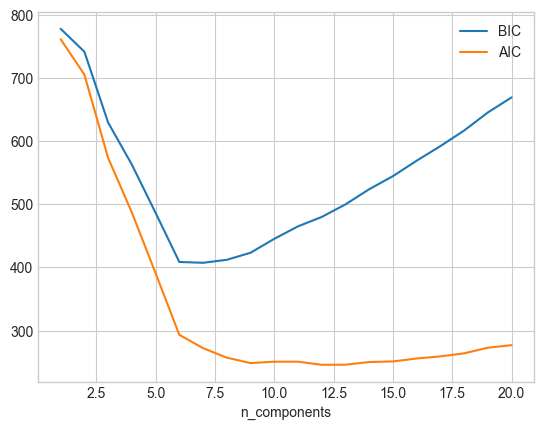

In [18]:
# how many components?
# the facts that a gmm is a generative model gives us a natural means of determining the optimal number of components for a given dataset and so we can simply evaluate the log-likelihood of the data under the model usng cross validation.
n_components = np.arange(1, 21)
models = [
    GaussianMixture(n, covariance_type="full", random_state=0).fit(Xmoon)
    for n in n_components
]
plt.plot(n_components, [m.bic(Xmoon) for m in models], label="BIC")
plt.plot(n_components, [m.aic(Xmoon) for m in models], label="AIC")
plt.legend(loc="best")
plt.xlabel("n_components")
# the optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. here we see that our choice of 16 components was perhaps not ideal; given this data we would probably favor something in the 8-12 range.
# notice that the important point: this choice of number of components measures how well gmm works as a density estimator, not how well it works as a clustering algorithm. i would encourage you to think of gmm primarily as a density estimator, and use it for clustering only when warranted within simple datasets.

GMMs for generating new data

In [19]:
# we can use GMM model to generate new handwritten digits
digits = load_digits()
digits.data.shape

(1797, 64)

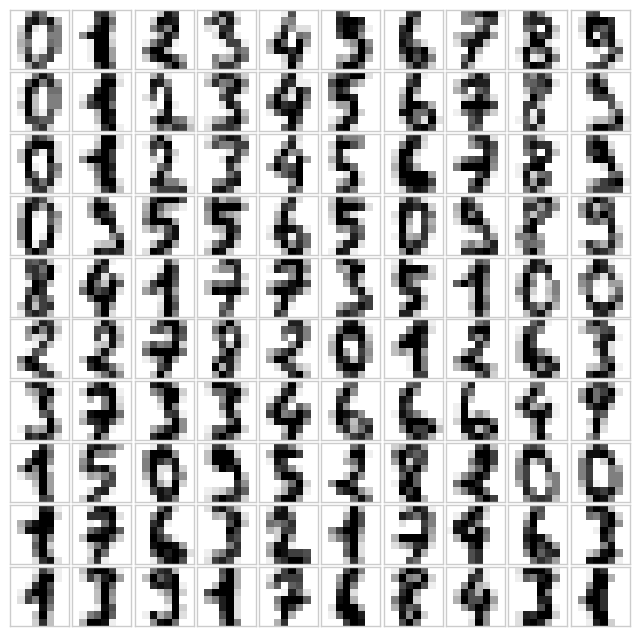

In [20]:
# next lets plot the first 50 of these to recall exactly what we're looking at.
def plot_digits(data):
    fig, ax = plt.subplots(
        10, 10, figsize=(8, 8), subplot_kw=dict(xticks=[], yticks=[])
    )
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap="binary")
        im.set_clim(0, 16)


plot_digits(digits.data)

In [21]:
# GMM have difficulty with high dimensional data so we will start by reducing the dimensionality of the digits data, retaining 99% of the variance using PCA.
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

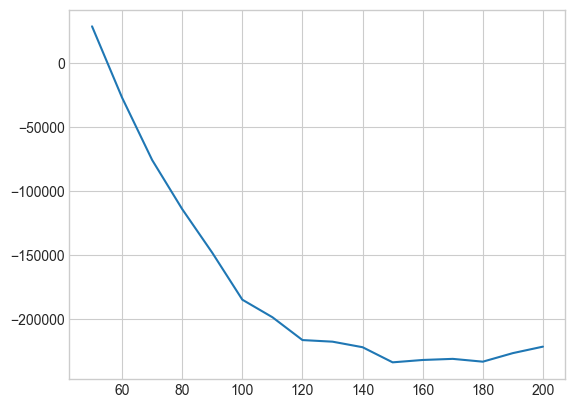

In [22]:
# given this projected data, we can use the AIC to get a gauge for the number of digits we should look for.
n_components = np.arange(50, 210, 10)
models = [
    GaussianMixture(n, covariance_type="full", random_state=0) for n in n_components
]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics)

In [23]:
gmm = GaussianMixture(150, covariance_type="full", random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [25]:
# we can draw samples of 100 new points within this 41-dimensional projected space, using the GMM as a generative model.
data_new, label_new = gmm.sample(100)
data_new.shape

(100, 41)

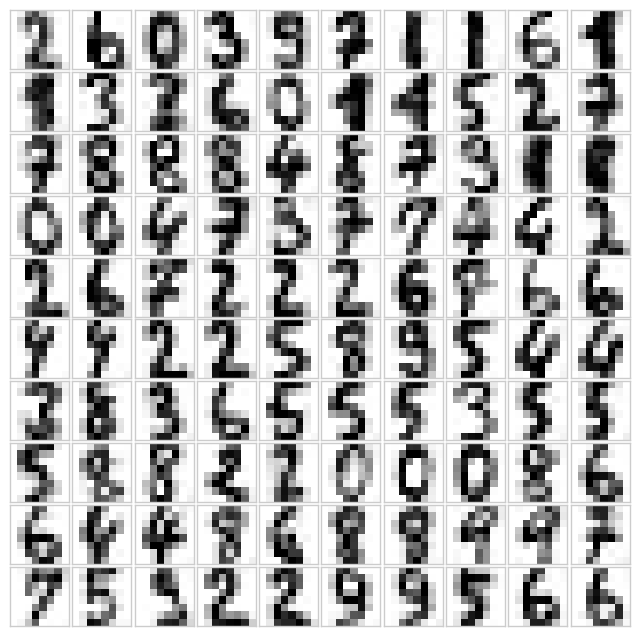

In [26]:
# finally we can use the inverse transform of the PCA object to construct the new digits.
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)